## Feature Engineering 1
In this assignment, you'll continue working with the Students Performance in Exams dataset from Kaggle. You should access the data from the Thinkful database.

In [1]:
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
# read in us education data 
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

grades = pd.read_sql_query('select * from studentsperformance',con=engine)

engine.dispose()

In [3]:
grades.columns = grades.columns.str.replace(' ', '_')
grades.columns = map(str.lower, grades.columns)

In [4]:
grades.head()

,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### 1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

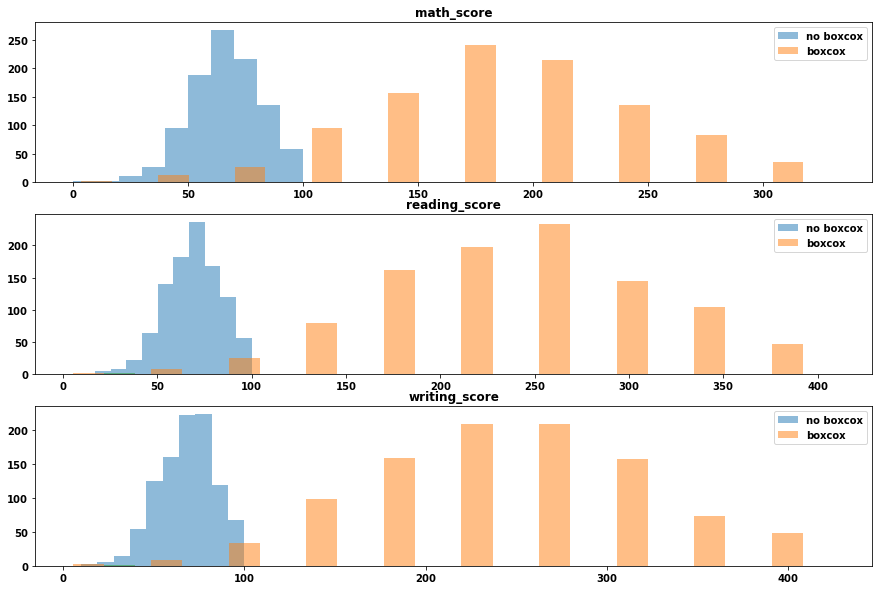

In [5]:
fig = plt.figure(figsize=(15,10))

# histograms of grades for each subject
for i, column in enumerate(grades.columns[-3:]):

    plt.subplot(3, 1, i+1)
    plt.title(column)
    plt.hist(grades.loc[:, column], alpha=.5, label= 'no boxcox')
    # add 1 to prevent any zero values from being included
    # this will prevent boxcox from working properly
    plt.hist(boxcox(grades.loc[:, column] + 1), alpha=.5, label= 'boxcox');
    plt.legend()

The boxcox transformation seems to cause the score distributions to be normal.

#### <font color=darkorange>But why do the boxcox histograms have large gaps?</font>

In [7]:
# trying to set up a for loop to run through
# columns that interest me and return statistics
# but I keep getting this error message

for column in grades.columns[-3:]:
    grades_boxcox,_ = boxcox(grades.loc[:, column]+1)
    print(jarque_bera(grades_boxcox))

(0.9076445139377781, 0.6351956248084886)
(4.098313001136366, 0.12884353721559627)
(4.712173664457964, 0.09479042923741077)


In [8]:
jarque_bera(grades_boxcox)

(4.712173664457964, 0.09479042923741077)

### 2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

In [9]:
# find mean score for all subjects for each student
grades.iloc[:,-3:].mean(axis=1).head()

0    72.666667
1    82.333333
2    92.666667
3    49.333333
4    76.333333
dtype: float64

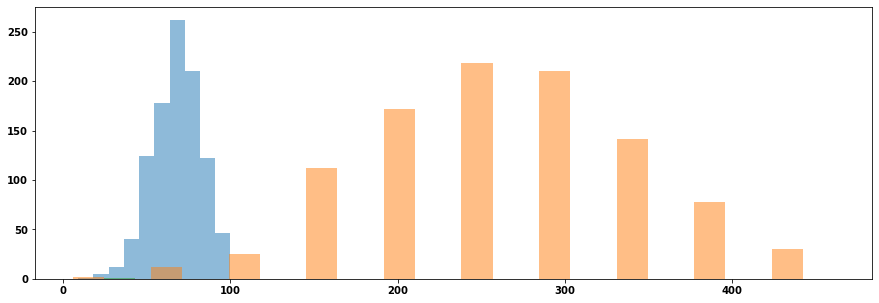

In [10]:
fig = plt.figure(figsize=(15,5))

plt.hist(grades.iloc[:,-3:].mean(axis=1), alpha=.5)
plt.hist(boxcox(grades.iloc[:,-3:].mean(axis=1)), alpha=.5);

In [11]:
# analyze distribution with jarque_bera to see if the distribution is normal
jarque_bera(grades.iloc[:,-3:].mean(axis=1))

(15.453387913085168, 0.00044089934264401887)

Based on the VERY small p-value, this distribution is not normal.  Simply examining the histogram visually, there is a slight tail towards lower values.

In [12]:
# assign output of boxcox transformation to variable
# this will allow me to analyse using jarque_bera to determine in the data is normal
grades_boxcox,_ = boxcox(grades.iloc[:,-3:].mean(axis=1))

Per discussion with mentor, boxcox is returning two outputs, and by adding the , and _ on the receiving end, I am able to unpack the two outputs into one object and one "dummy" object.

In [13]:
# check to see if the data is normal
jarque_bera(grades_boxcox)

(2.4353989331279173, 0.29591013563984203)

#### <font color=darkorange>The p-value for normal distribution is still less than 1, which means this is still not a normal distribution.  Per Thinkful module "The p-values are 0 which indicates that the distribution of the log transformed variables is statistically different from the normal distribution."</font>

In [14]:
# check to see if the data is normal
normaltest(grades_boxcox)

NormaltestResult(statistic=2.779857602227616, pvalue=0.24909303914726724)

It seems the grades are now normal after using boxcox.

### 3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

In descending order of importance, these are the variables I think would be the most directly related to grades.
1. lunch
2. education of parent
3. study course
4. ethnicity
5. gender 

<BarContainer object of 2 artists>

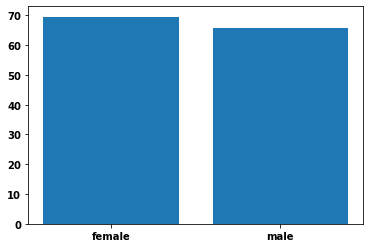

In [16]:
# bar chart to compare sore of female students against ma
plt.bar(pd.concat([grades.iloc[:,-3:].mean(axis=1), grades.gender], axis=1).groupby('gender').mean().index,
        height=pd.concat([grades.iloc[:,-3:].mean(axis=1), grades.gender], axis=1).groupby('gender').mean().iloc[:,0])

female students have higher grades than males on average

<BarContainer object of 5 artists>

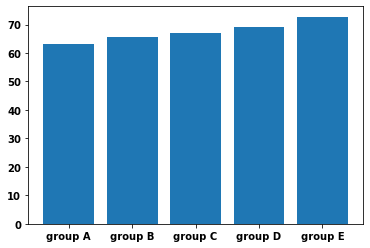

In [17]:
plt.bar(pd.concat([grades.iloc[:,-3:].mean(axis=1), 
                   grades['race/ethnicity']], axis=1).groupby('race/ethnicity').mean().index, \
            height = pd.concat([grades.iloc[:,-3:].mean(axis=1), 
                   grades['race/ethnicity']], axis=1).groupby('race/ethnicity').mean().iloc[:,0])

Group E ethnicity has the highest mean grades, with group A having the lowest scores.

([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

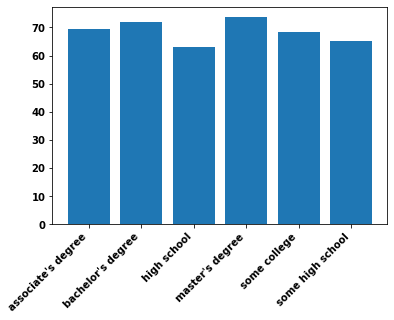

In [18]:
ax = plt.bar(pd.concat([grades.iloc[:,-3:].mean(axis=1), 
                   grades.parental_level_of_education], axis=1).groupby(grades.parental_level_of_education).mean().index, \
            height = pd.concat([grades.iloc[:,-3:].mean(axis=1), 
                   grades.parental_level_of_education], axis=1).groupby(grades.parental_level_of_education).mean().iloc[:,0])
plt.xticks(rotation=45, horizontalalignment='right')

Parents with a masters degree are associated with the students who have the highest mean grades.

<BarContainer object of 2 artists>

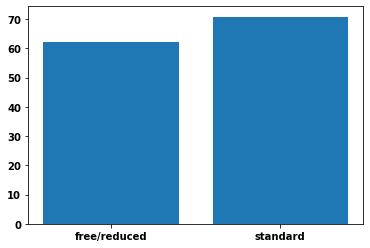

In [19]:
plt.bar(pd.concat([grades.iloc[:,-3:].mean(axis=1), 
                   grades.lunch], axis=1).groupby(grades.lunch).mean().index, \
            height = pd.concat([grades.iloc[:,-3:].mean(axis=1), 
                   grades.lunch], axis=1).groupby(grades.lunch).mean().iloc[:,0])

Students with free/reduced lunches don't do as well as students with standard lunches.  The need for a free/reduced lunch seems to be an indicator that these students don't the resources of other students - which might include extra tutoring help.

<BarContainer object of 2 artists>

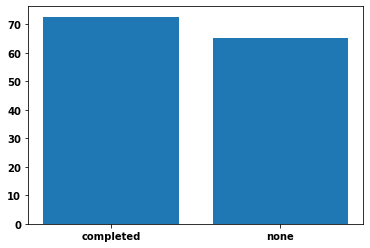

In [20]:
# visualize difference
plt.bar(pd.concat([grades.iloc[:,-3:].mean(axis=1), 
                   grades.test_preparation_course], axis=1).groupby(grades.test_preparation_course).mean().index, \
            height = pd.concat([grades.iloc[:,-3:].mean(axis=1), 
                   grades.test_preparation_course], axis=1).groupby(grades.test_preparation_course).mean().iloc[:,0])